# Model 17: Reinforcement learning

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model17.html

## Introduction

- 文化進化研究は個人的な学習 (learning on one’s own) よりも社会的な学習 (learning from others) により多くの注意を払ってきたことは否定できない。
- 本チュートリアルでも、個人的学習に関しては[Model 2: Unbiased and biased mutation](https://github.com/mas178/social-simulation/blob/main/Mesoudi2021/model02_unbiased_and_biased_mutation.ipynb)で触れたのみである。
    - Model 2では、個人はある一定の確率で、ランダムに新しい文化特性を身に着けた。
    - これは妥当なスターティングポイントではあるものの、より心理学的な側面に着目したモデルが考えうるだろう。
- Model 17 では、Reinforcement Learning (強化学習) を実装する。
    - 強化学習は、様々なディシプリン (心理学、機械学習、etc.) において個人的学習をモデル化する方法として採用されている。
    - 好ましい行動や意思決定には報酬が与えられ、好ましくない行動には報酬が与えられないことによって、好ましい行動を学習する仕組み。
- Model 17 では、文化進化の文脈で強化学習によって個人的学習をシミュレートする方法と、社会的学習と組み合わせる方法を見ていく。
- また、Statistical Appendix では、統計データからシミュレーションのパラメータを推定する方法を確認する。

## Model 17a: Reinforcement learning with a single agent

In [1]:
using JupyterFormatter
enable_autoformat()

using DataFrames
using Distributions
using StatsBase
using LaTeXStrings
using Plots
using Random
using Test: @test, @testset

println("Julia version: ", VERSION)

Julia version: 1.9.0


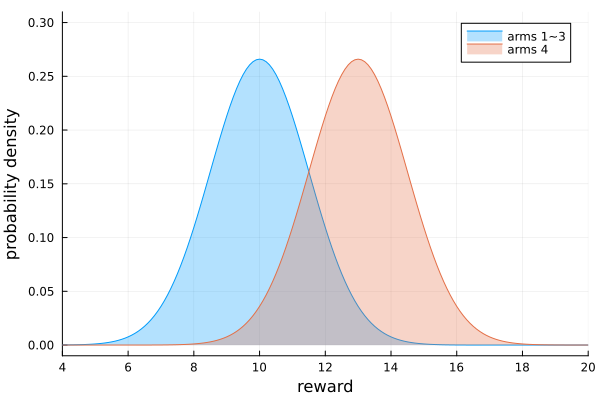

In [2]:
# define parameters of the 4-armed bandit task
arm_μ = [10, 10, 10, 13]
arm_σ = 1.5

plot(
    xlab = "reward",
    ylab = "probability density",
    xlim = [4, 20],
    ylim = [-0.01, 0.31],
    xticks = 4:2:20,
    yticks = 0.0:0.05:0.3,
)

x_vals = -10:0.1:100

density_vals = pdf.(Normal(arm_μ[1], arm_σ), x_vals)
plot!(x_vals, density_vals, label = "arms 1~3", fillrange = 0, fillalpha = 0.3)

density_vals = pdf.(Normal(arm_μ[4], arm_σ), x_vals)
plot!(x_vals, density_vals, label = "arms 4", fillrange = 0, fillalpha = 0.3)

- This is made more concrete by picking 10 values from each arm’s reward distribution:

In [3]:
picking_10_values = [round.(Int, rand(Normal(μ, arm_σ), 10)) for μ in arm_μ]
picking_10_values = hcat(picking_10_values...)
picking_10_values = DataFrame(picking_10_values', ["$i" for i = 1:10])
insertcols!(picking_10_values, 1, :Arm => ["Arm $i" for i = 1:4])

Row,Arm,1,2,3,4,5,6,7,8,9,10
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Arm 1,9,9,9,10,11,9,9,10,11,8
2,Arm 2,9,9,11,13,13,13,11,10,9,11
3,Arm 3,8,11,10,9,7,12,13,9,9,10
4,Arm 4,15,16,13,11,14,12,14,11,14,13


- ある1人のエージェントがいるとする。
- 10回アームを回して、合計ポイントを最大化することを目指す。
- 各アームが出すポイントの期待値には差があるかもしれない。($\sigma$が増えると問題はより難しくなる)
- 戦略の例。最初の4回で、各アームを1回ずつ回し (exploration)、最大ポイントを出したアームを次の6回で回し続ける (exploitation)。
- exploration を増やすと情報の信頼性は上がるが、情報を活用 (exploitation) する機会が減る。
- しかし、exploitation を増やし、exploration を減らすと、情報の信頼性が下がり誤った情報に基づいて exploitation する可能性が増える。
- この exploration と exploitation のトレードオフのバランスをとるアルゴリズムを Model 17a として実装する。

### Q value

- Q values: the agent’s numerical estimation of the value of each arm.
- On the first trial ($t = 1$) we’ll set each Q value to zero, as shown above.
    - This indicates that the agent has no initial preference for any of the arms.
    - If we had prior knowledge about the arms we might set different values, but for now equal preferences is a reasonable assumption.

In [4]:
Q_values = fill(0.0, 4)

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

### Softmax function

- Now we convert these values into probabilities, specifying the probability that the agent chooses each arm on the next trial.
    - This is where the exploitation-exploration trade-off is addressed.
    - We use what is called a ‘softmax’ function, which converts any set of values into probabilities that sum to one (as probabilities must) and weights the probabilities according to those values.
    - The higher the relative value, the higher the relative probability.
- The softmax function contains a parameter $\beta$, often called ‘inverse temperature’, that determines how exploitative the agent is (sometimes expressed as how ‘greedy’ the agent is).
    - When $\beta = 0$, arms are chosen entirely at random with no influence of the Q values.
    - This is super exploratory, as the agent continues to choose all arms irrespective of observed rewards.
    - As $\beta$ increases, there is a higher probability of picking the arm with the highest Q value.
    - This is increasingly exploitative (or ‘greedy’).
    - When $\beta$ is very large then only the arm that currently has the highest Q value will be chosen, even if other arms might actually be better.
- Mathematically, the softmax function looks like this:
$$
p_i = \frac{e^{\beta Q_i}}{\sum_{j = 1}^{k} e^{\beta Q_j}} \tag{17.1}
$$

In [5]:
function get_probabilities(Q_values::Vector{Float64}, β::Float64)::Vector{Float64}
    # softmax function
    exp_x = exp.(Q_values .* β)

    return exp_x ./ sum(exp_x)
end

get_probabilities (generic function with 1 method)

In [6]:
@testset "get_probabilities" begin
    @testset "β = 0.0" begin
        β = 0.0

        Q_values = fill(0.0, 4)
        @test get_probabilities(Q_values, β) == [0.25, 0.25, 0.25, 0.25]

        Q_values = [10.0, 14.0, 9.0, 13.0]
        @test get_probabilities(Q_values, β) == [0.25, 0.25, 0.25, 0.25]
    end

    @testset "β = 0.3" begin
        β = 0.3

        Q_values = fill(0.0, 4)
        @test get_probabilities(Q_values, β) == [0.25, 0.25, 0.25, 0.25]

        Q_values = [10.0, 14.0, 9.0, 13.0]
        @test get_probabilities(Q_values, β) ≈ [0.133, 0.441, 0.099, 0.327] atol = 0.001
    end

    @testset "β = 5.0" begin
        β = 5.0

        Q_values = fill(0.0, 4)
        @test get_probabilities(Q_values, β) == [0.25, 0.25, 0.25, 0.25]

        Q_values = [10.0, 14.0, 9.0, 13.0]
        @test get_probabilities(Q_values, β) ≈ [0.0, 0.993, 0.0, 0.007] atol = 0.001
    end
end;

Test Summary:     | Pass  Total  Time
get_probabilities |    6      6  0.7s


### Make choice

In [7]:
arms = 1:4
Q_values = fill(0.0, length(arms))
β = 0.3
probabilities = get_probabilities(Q_values, β)
choice = sample(arms, Weights(probabilities))

3

### Get reward

In [8]:
arm_μ = [10, 10, 10, 13]
arm_σ = 1.5

get_reward(μ::Int, σ::Float64)::Int = round(Int, first(rand(Normal(μ, σ), 1)));

reword = get_reward(arm_μ[choice], arm_σ)

8

### Update Q values

- Finally, the agent updates its Q values given the reward.
- The extent to which Q values are updated is controlled by a second parameter, $\alpha$, which ranges from $0$ to $1$.
    - When $\alpha = 0$ there is no updating and the reward has no effect on Q values.
    - When $\alpha = 1$ the Q value for the rewarded arm increases by the full reward amount.
    - When $0 < \alpha < 1$ the Q value for the rewarded arm increases by a proportion $\alpha$ of the reward.
- There is again a trade-off here.
    - Obviously $\alpha = 0$ is no good because the agent is not learning.
    - However, if $\alpha$ is too large then the agent can prematurely focus on an arm that gives a high reward early on, without exploring other arms.

In [9]:
α = 0.7
Q_values[choice] += α * (reword - Q_values[choice])
Q_values

4-element Vector{Float64}:
 0.0
 0.0
 5.6
 0.0

### Run all

- Every 25 timesteps we will change which arm gives the higher reward.
- This lets us see whether our reinforcement algorithm can handle environmental change, rather than blindly sticking with arm 4 even after it is no longer optimal.

In [10]:
struct Arm
    μ::Matrix{Int}
    σ::Float64
end

In [11]:
arm = Arm(
    [
        10 10 10 13
        10 13 10 10
        13 10 10 10
        10 10 13 10
    ],
    1.5,
);

In [12]:
function get_correct_arms(arm_μ::Matrix{Int}, agent_N::Int, time_steps::Int)::Vector{Int}
    _, arm_generations = size(arm_μ)
    correct_arm = vec(mapslices(argmax, arm_μ, dims = 2))
    repeat(correct_arm, inner = round(Int, time_steps / arm_generations) * agent_N)
end;

In [13]:
function RL_single(
    arm::Arm;
    α::Float64, # strength of learning
    β::Float64, # controll the tradeoff (softmax function)
)::DataFrame
    arm_count, _ = size(arm.μ)
    time_steps = 100

    Q_values = fill(0.0, arm_count)

    output_df = DataFrame(
        arm1 = Vector{Float64}(undef, 0),
        arm2 = Vector{Float64}(undef, 0),
        arm3 = Vector{Float64}(undef, 0),
        arm4 = Vector{Float64}(undef, 0),
        choice = Vector{Int}(undef, 0),
        reward = Vector{Int}(undef, 0),
        correct = Vector{Bool}(undef, 0),
    )

    for time_step = 1:time_steps
        # get softmax probabilities from Q_values and beta
        probabilities = get_probabilities(Q_values, β)

        # choose an arm based on probs
        choice = sample(1:arm_count, Weights(probabilities))

        # get reward
        arm_μ_row = (time_step - 1) ÷ 25 + 1
        reword = get_reward(arm.μ[arm_μ_row, choice], arm.σ)

        # update Q_values for choice based on reward and alpha
        Q_values[choice] += α * (reword - Q_values[choice])

        # store all in output dataframe
        push!(output_df, (Q_values..., choice, reword, false), promote = true)
    end

    # record whether correct
    output_df.correct .= (output_df.choice .== get_correct_arms(arm.μ, 1, time_steps))

    return output_df
end;

In [14]:
result = RL_single(arm, α = 0.7, β = 0.3)
display(result[1:25, :])
display(result[76:100, :])

Row,arm1,arm2,arm3,arm4,choice,reward,correct
,Float64,Float64,Float64,Float64,Int64,Int64,Bool
1,0.0,0.0,0.0,7.0,4,10,true
2,0.0,0.0,0.0,11.2,4,13,true
3,0.0,8.4,0.0,11.2,2,12,false
4,0.0,8.4,0.0,12.46,4,13,true
5,0.0,9.52,0.0,12.46,2,10,false
6,0.0,9.52,0.0,12.138,4,12,true
7,0.0,8.456,0.0,12.138,2,8,false
8,0.0,8.456,0.0,13.4414,4,14,true
9,0.0,9.5368,0.0,13.4414,2,10,false


Row,arm1,arm2,arm3,arm4,choice,reward,correct
,Float64,Float64,Float64,Float64,Int64,Int64,Bool
1,8.4,11.0446,0.0,10.5137,2,12,false
2,8.4,11.0446,0.0,7.3541,4,6,false
3,8.4,9.61339,0.0,7.3541,2,9,false
4,8.82,9.61339,0.0,7.3541,1,9,false
5,10.346,9.61339,0.0,7.3541,1,11,false
6,10.346,9.61339,0.0,11.3062,4,13,false
7,10.346,9.61339,0.0,12.4919,4,13,false
8,10.346,8.48402,0.0,12.4919,2,8,false
9,10.346,8.48402,0.0,10.0476,4,9,false


- Each run will be different, but you can see the Q values gradually updating over these 25 timesteps.
- Perhaps arm 3 ends the period with the highest Q value. Perhaps not.
- Possibly not all arms got explored.
- The task is difficult and this learning algorithm is not perfect.
- But some learning is occurring.

## Model 17b: Reinforcement learning with multiple agents

- RL_singleを複数エージェント化する目的は以下の3点。
    1. We are effectively adding multiple independent runs to RL_single as we have done with previous models to better understand the stochasticity in our results.
    1. This allows us in Model 17c to build in social learning between the multiple agents.
    1. We can introduce agent heterogeneity (individual variation / individual differences).
        - In previous models we have assumed that all agents have the same global parameter values.
        - Here instead we will introduce heterogeneity amongst the agents in parameter values $\alpha$ and $\beta$.
        - This simulates a situation where agents differ in their reinforcement learning parameters.
        - The latter might better resemble reality, where some people are more exploratory than others, some more conservative than others.
- Each of $N$ agents therefore has an $\alpha$ and $\beta$ drawn from a normal distribution with mean $\alpha_\mu$ and $\beta_\mu$, and standard deviation $\alpha_\sigma$ and $\beta_\sigma$, respectively.
    - When the standard deviations are zero, all agents have identical $\alpha$ and $\beta$, and we are doing independent runs with identical parameters for all agents.
    - When the standard deviations are greater than zero, we are simulating heterogeneity amongst agents.
    - Note that we add some code to bound $\alpha$ between zero and one, and $\beta$ greater than zero, otherwise our reinforcement learning algorithm won’t work properly.

In [15]:
struct Agents
    N::Int
    arm_count::Int
    α_μ::Float64
    α_σ::Float64
    α_vec::Vector{Float64}
    β_μ::Float64
    β_σ::Float64
    β_vec::Vector{Float64}
    s::Union{Nothing,Float64}
    s_μ::Union{Nothing,Float64}
    s_σ::Union{Nothing,Float64}
    s_vec::Union{Nothing,Vector{Float64}}
    f::Union{Nothing,Float64}
    f_μ::Union{Nothing,Float64}
    f_σ::Union{Nothing,Float64}
    f_vec::Union{Nothing,Vector{Float64}}
    Q_values::Matrix{Float64}
end

In [16]:
function Agents(;
    N::Int = 200,
    arm_count::Int = 4,
    α_μ::Float64 = 0.7,
    α_σ::Float64 = 0.1,
    β_μ::Float64 = 0.3,
    β_σ::Float64 = 0.1,
    s::Union{Nothing,Float64} = nothing,
    s_μ::Union{Nothing,Float64} = nothing,
    s_σ::Union{Nothing,Float64} = nothing,
    f::Union{Nothing,Float64} = nothing,
    f_μ::Union{Nothing,Float64} = nothing,
    f_σ::Union{Nothing,Float64} = nothing,
)::Agents
    α_vec = rand(Normal(α_μ, α_σ), N) # learning rates
    α_vec[α_vec.<0] .= 0.0
    α_vec[α_vec.>1] .= 1.0

    β_vec = rand(Normal(β_μ, β_σ), N) # inverse temperatures
    β_vec[β_vec.<0] .= 0.0

    if s_μ !== nothing
        s_vec = rand(Normal(s_μ, s_σ), N) # learning rates
        s_vec[s_vec.<0] .= 0.0
        s_vec[s_vec.>1] .= 1.0
    else
        s_vec = nothing
    end

    if f_μ !== nothing
        f_vec = rand(Normal(f_μ, f_σ), N) # learning rates
        f_vec[f_vec.<0] .= 0.0
    else
        f_vec = nothing
    end

    Q_values = fill(0.0, N, arm_count)

    Agents(
        N,
        arm_count,
        α_μ,
        α_σ,
        α_vec,
        β_μ,
        β_σ,
        β_vec,
        s,
        s_μ,
        s_σ,
        s_vec,
        f,
        f_μ,
        f_σ,
        f_vec,
        Q_values,
    )
end

function get_title(agents::Agents)::String
    title = "$(L"α_μ = ")$(agents.α_μ), $(L"α_σ =")$(agents.α_σ), $(L"β_μ =")$(agents.β_μ), $(L"β_σ =")$(agents.β_σ)"

    if agents.s !== nothing && agents.f !== nothing
        title *= "$(L"s = ")$(agents.s), $(L"f = ")$(agents.f)"
    end

    return title
end

function get_probabilities(agents::Agents)::Matrix{Float64}
    exp_x = exp.(agents.Q_values .* agents.β_vec)

    return exp_x ./ sum(exp_x, dims = 2)
end;

function get_probabilities(
    agents::Agents,
    time_step::Int,
    output_df::DataFrame,
)::Matrix{Float64}
    # vector to hold frequencies of choices for conformity
    n = fill(0, agents.arm_count)

    # get softmax probabilities from Q_values and beta
    probabilities = get_probabilities(agents)

    if time_step > 1
        # get number of agents who chose each option
        for arm = 1:agents.arm_count
            n[arm] = sum(output_df[output_df.trial.==(time_step-1), :choice] .== arm)
        end

        # conformity according to f
        prob_SL = if agents.f !== nothing
            n .^ agents.f ./ sum(n .^ agents.f)
        else
            [n .^ f ./ sum(n .^ f) for f in agents.f_vec]
        end

        # convert p_SL to N-row matrix to match p_RL
        prob_SL = repeat(prob_SL', outer = agents.N)

        # update probabilities by combining p_RL and p_SL according to s
        probabilities = if agents.s !== nothing
            probabilities .* (1 - agents.s) .+ prob_SL .* agents.s
        else
            p = [
                probabilities[i, :] .* (1 - agents.s_vec[i]) .+
                prob_SL[i]' .* agents.s_vec[i] for i = 1:agents.N
            ]
            hcat(p...)'
        end
    end

    return probabilities
end;

In [17]:
function make_output_df(N::Int, time_steps::Int)::DataFrame
    DataFrame(
        trial = repeat(1:time_steps, inner = N),
        agent = repeat(1:N, outer = time_steps),
        choice = fill(0, time_steps * N),
        reward = fill(0, time_steps * N),
        correct = fill(false, time_steps * N),
    )
end;

In [18]:
df = make_output_df(100, 2)
df.choice .= repeat([1, 1, 1, 1, 2, 2, 2, 3, 3, 4], 20)
get_probabilities(Agents(s_μ = 0.5, s_σ = 0.1, f_μ = 0.5, f_σ = 0.1), 2, df)

200×4 Matrix{Float64}:
 0.291945  0.267388  0.238657  0.20201
 0.293626  0.268085  0.238203  0.200087
 0.286621  0.265181  0.240097  0.208102
 0.276095  0.260818  0.242943  0.220144
 0.287001  0.265338  0.239994  0.207667
 0.276612  0.261032  0.242803  0.219552
 0.290749  0.266892  0.23898   0.203378
 0.301724  0.271442  0.236012  0.190821
 0.291915  0.267375  0.238665  0.202045
 0.287944  0.26573   0.239739  0.206587
 0.290487  0.266784  0.239051  0.203678
 0.283252  0.263784  0.241008  0.211956
 0.283521  0.263896  0.240935  0.211649
 ⋮                             
 0.2817    0.263141  0.241427  0.213731
 0.293558  0.268057  0.238221  0.200165
 0.28117   0.262921  0.241571  0.214338
 0.300472  0.270923  0.236351  0.192254
 0.297075  0.269515  0.23727   0.196141
 0.287385  0.265498  0.23989   0.207227
 0.281795  0.26318   0.241402  0.213623
 0.285714  0.264805  0.240342  0.209138
 0.290931  0.266967  0.238931  0.203171
 0.300687  0.271012  0.236293  0.192009
 0.283741  0.263987  0.240

In [19]:
function RL_multiple(agents::Agents, arm::Arm, time_steps::Int = 100)::Nothing
    arm_count, _ = size(arm.μ)

    output_df = make_output_df(agents.N, time_steps)

    for time_step = 1:time_steps
        # get softmax probabilities from Q_values and beta
        probabilities = get_probabilities(agents)

        # choose an arm based on probs
        choices = [sample(1:arm_count, Weights(probs)) for probs in eachrow(probabilities)]

        # get rewards
        arm_μ_row = (time_step - 1) ÷ 25 + 1
        rewards = [get_reward(arm.μ[arm_μ_row, choice], arm.σ) for choice in choices]

        # update Q values
        for i = 1:agents.N
            agents.Q_values[i, choices[i]] +=
                agents.α_vec[i] * (rewards[i] - agents.Q_values[i, choices[i]])
        end

        # store choice and reward in output
        output_df[output_df.trial.==time_step, :choice] .= choices
        output_df[output_df.trial.==time_step, :reward] .= rewards
    end

    # record whether correct
    output_df.correct .=
        (output_df.choice .== get_correct_arms(arm.μ, agents.N, time_steps))

    plot_output(output_df, get_title(agents))
end;

In [20]:
function plot_output(df::DataFrame, title::String = "")::Nothing
    _df = combine(groupby(df, :trial), :correct => mean)
    p = plot(
        _df.trial,
        _df.correct_mean,
        ylim = (0, 1),
        title = title,
        xlab = "timestep",
        ylab = "frequency correct",
        legend = false,
    )
    vline!([25, 50, 75], linestyle = :dash, lw = 0.5, color = :gray)
    hline!([0.25], linestyle = :dash, lw = 0.5, color = :gray)

    display(p)
end;

### Model 17b 実験1

標準偏差を増やすと学習が困難になる。

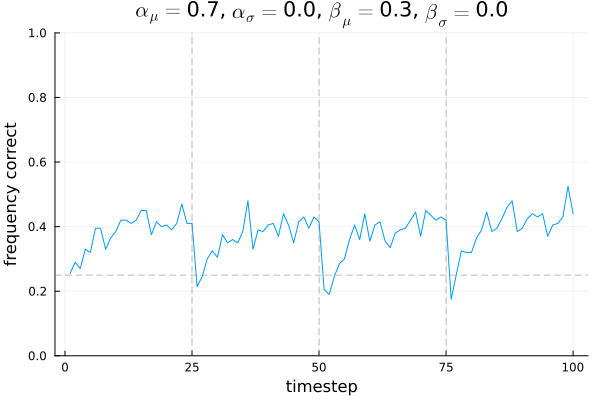

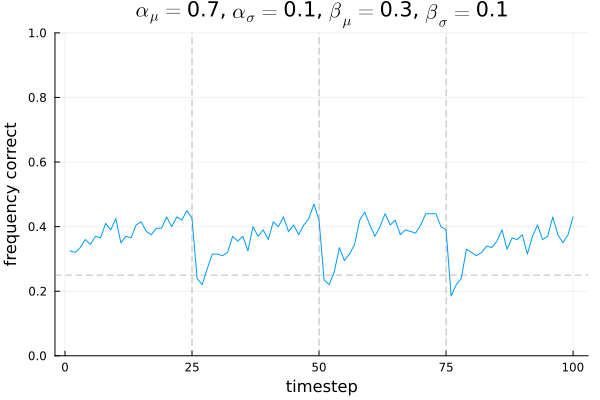

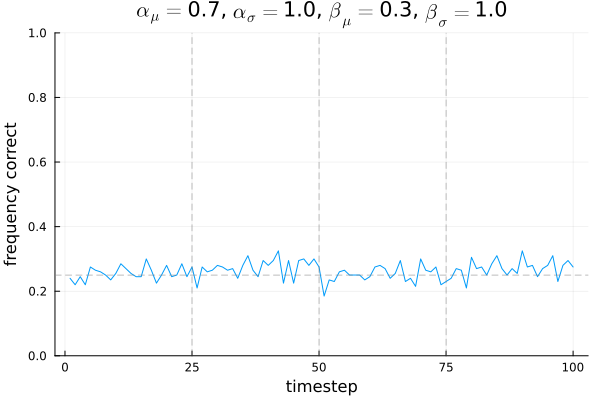

In [21]:
RL_multiple(Agents(α_σ = 0.0, β_σ = 0.0), arm)
RL_multiple(Agents(α_σ = 0.1, β_σ = 0.1), arm)
RL_multiple(Agents(α_σ = 1.0, β_σ = 1.0), arm)

### Model 17b 実験2

$\beta$ が小さすぎる ($\beta_\mu = 0.1$) と、学習ばかりして、学習の成果を得ることができない。

$\beta$ が大きすぎる ($\beta_\mu = 1.0$) と、学習をせずに、最初にたまたま選んだarmを最後まで選び続ける。

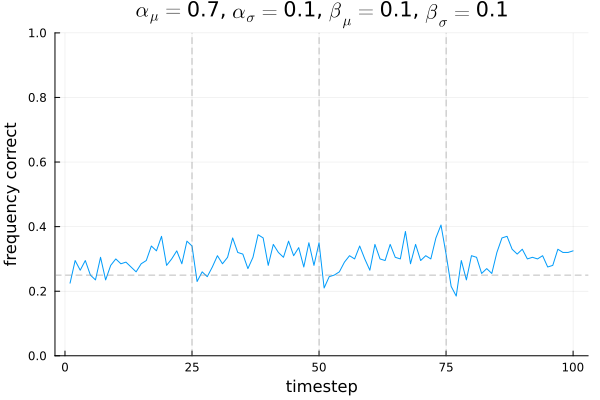

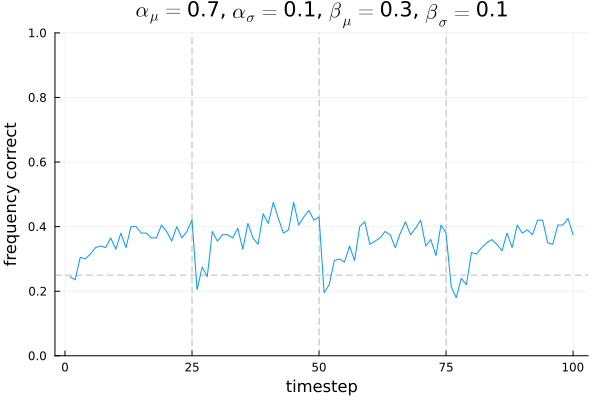

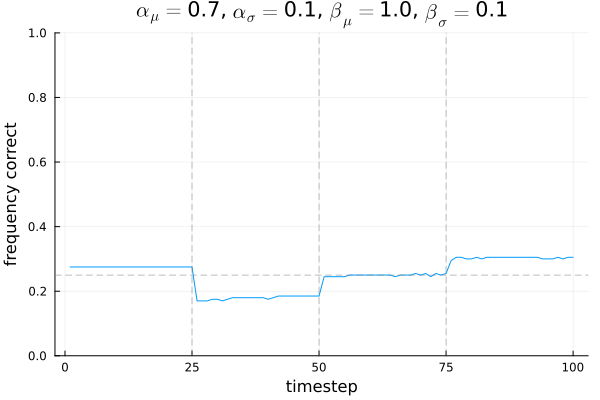

In [22]:
RL_multiple(Agents(β_μ = 0.1), arm)
RL_multiple(Agents(β_μ = 0.3), arm)
RL_multiple(Agents(β_μ = 1.0), arm)

## Model 17c: Reinforcement learning plus social learning

- In model 17c, agents will be able to update their Q values not only using their own personal rewards, but also the choices of the other agents.
- To implement social learning we use two new parameters.
    - $s$: the probability on each trial that an agent engages in social learning, rather than the reinforcement learning
        - $s = 0$: indivisual learning only
        - $s = 1$: social learning only
    - $f$: the strength of conformity bias
        - $f = 1$: unbiased
        - $f > 1$: conformity bias

In [23]:
function RL_social(
    agents::Agents,
    arm::Arm,
    time_steps::Int = 100,
    random_seed::Int = 1,
)::Nothing
    Random.seed!(random_seed)

    output_df = make_output_df(agents.N, time_steps)

    for time_step = 1:time_steps
        # get softmax probabilities from Q_values and beta
        probabilities = get_probabilities(agents, time_step, output_df)

        # choose an arm based on probs
        choices =
            [sample(1:agents.arm_count, Weights(probs)) for probs in eachrow(probabilities)]

        # get rewards
        arm_μ_row = (time_step - 1) ÷ 25 + 1
        rewards = [get_reward(arm.μ[arm_μ_row, choice], arm.σ) for choice in choices]

        # update Q values
        for i = 1:agents.N
            agents.Q_values[i, choices[i]] +=
                agents.α_vec[i] * (rewards[i] - agents.Q_values[i, choices[i]])
        end

        # store choice and reward in output
        output_df[output_df.trial.==time_step, :choice] .= choices
        output_df[output_df.trial.==time_step, :reward] .= rewards
    end

    # record whether correct
    output_df.correct .=
        (output_df.choice .== get_correct_arms(arm.μ, agents.N, time_steps))

    plot_output(output_df, get_title(agents))
end;


### Model 17c 実験1

- 社会的学習を全く行わない場合 ($s = 0.0$、つまり Model 17b) と比較して、$s = 0.3$の場合、結果が改善する。
- しかし、$s = 1.0$の様に社会的学習の影響度が強すぎる場合は、多数派に流されてしまい結果が安定しない。

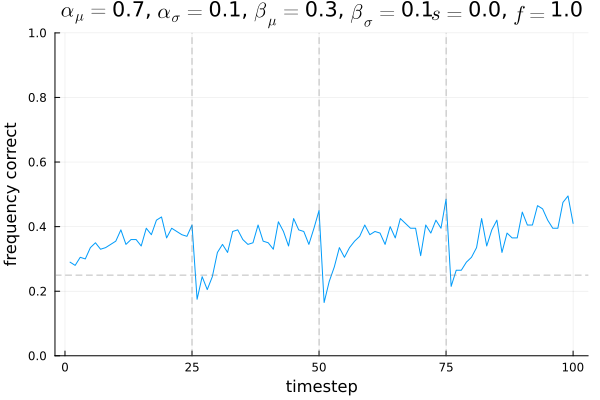

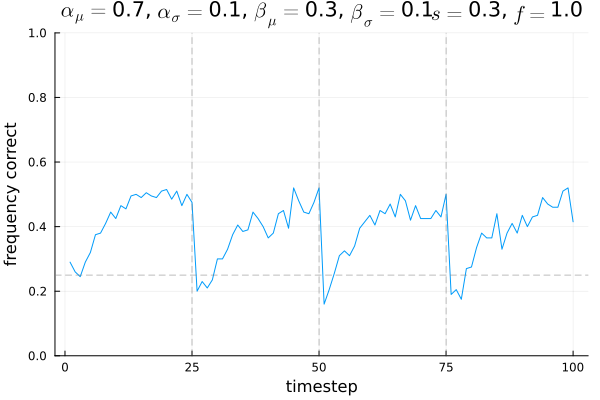

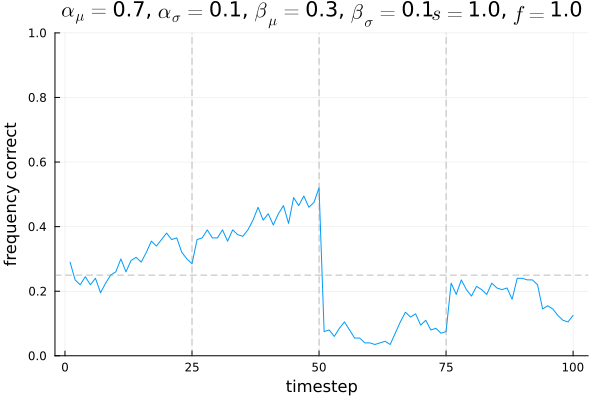

In [24]:
RL_social(Agents(s = 0.0, f = 1.0), arm)
RL_social(Agents(s = 0.3, f = 1.0), arm)
RL_social(Agents(s = 1.0, f = 1.0), arm)

### Model 17c 実験2

- 実験1で最もパフォーマンスの良かった、$s = 0.3, f = 1.0$ の場合を基準に、Conformity bias の強度 ($f$) を変化させる。
- $f$を減らすとパフォーマンスは低下する。(社会的学習の効果が消えModel17bの結果に近づく。)
- $f$を$2.0$に増やすとパフォーマンスは改善する。
- しかし、$f$を増やしすぎる($10.0$)とパフォーマンスは安定しなくなる。

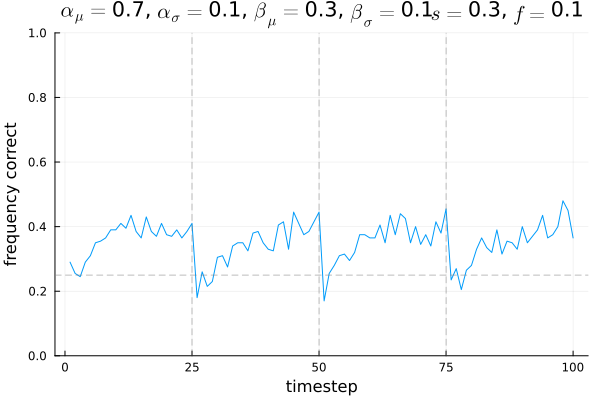

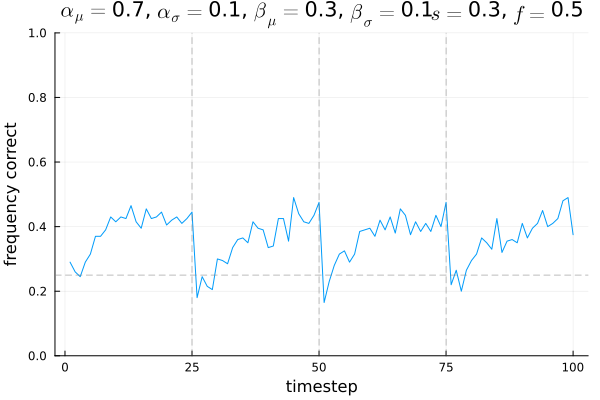

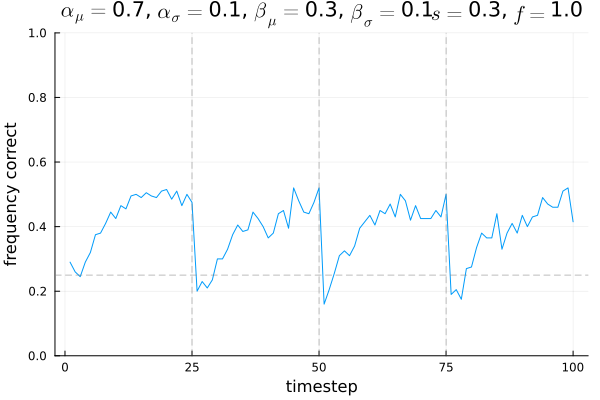

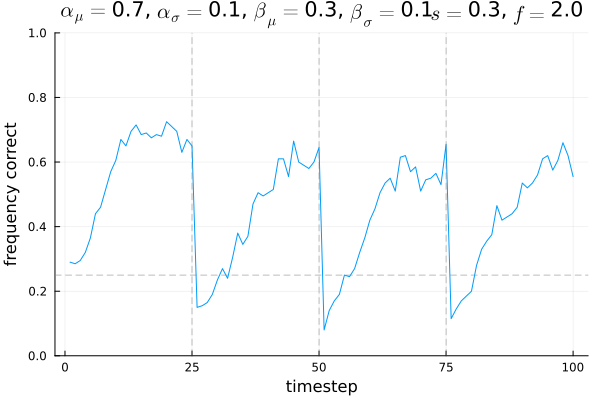

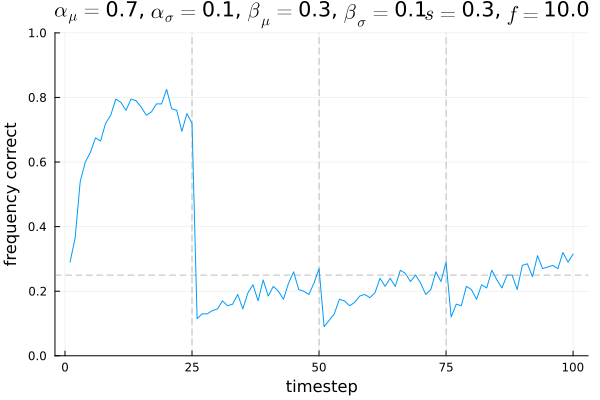

In [25]:
RL_social(Agents(s = 0.3, f = 0.1), arm)
RL_social(Agents(s = 0.3, f = 0.5), arm)
RL_social(Agents(s = 0.3, f = 1.0), arm)
RL_social(Agents(s = 0.3, f = 2.0), arm)
RL_social(Agents(s = 0.3, f = 10.0), arm)

### Model 17c 実験3

$s$と$f$の値は、全エージェント共通である場合でも、各エージェントで確率的に異なる (heterogeneous) 場合でも、結果に違いはない。

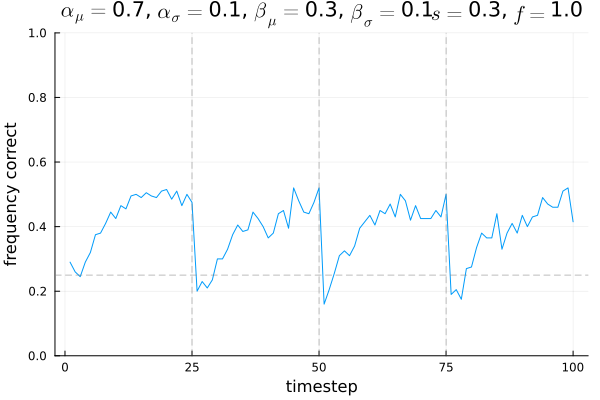

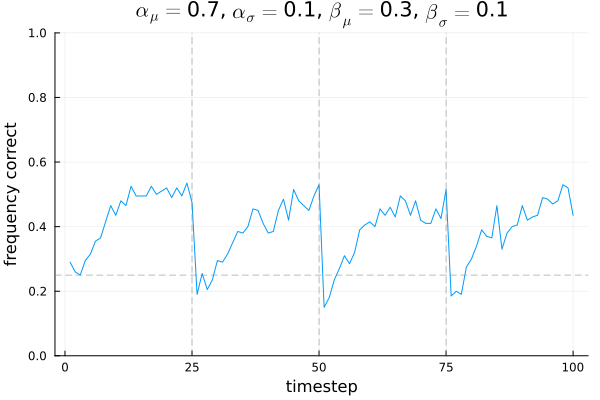

In [26]:
RL_social(Agents(s = 0.3, f = 1.0), arm)
RL_social(Agents(s_μ = 0.3, s_σ = 0.1, f_μ = 1.0, f_σ = 0.1), arm)

## Summary

- 個人的学習 (強化学習) によってある程度正しい学習を行うことができる。
- 社会的学習を程よく個人的的学習に混ぜると、学習のパフォーマンスが向上する。
- しかし、社会的学習の影響力を強くしすぎると、個人が正しい解を見つける前に、多数派に流されてしまい、学習のパフォーマンスが安定しなくなる。

## Statistical Appendix